In [1]:
# Ko-FinBERT + Active Learning 기반 ESG 뉴스 감성 분석 (1차 & 2차 파인튜닝 모두 epoch 7~10 테스트)

from transformers import AutoConfig,AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
import glob
from tabulate import tabulate

# 공통 설정
model_name = "snunlp/KR-FinBert-SC"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is depre

# 1. 함수

In [2]:
# 평가 지표 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'eval_accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [3]:
# 지정한 epoch에 해당하는 모델을 평가 결과 CSV에서 찾아 로드하는 함수
def load_model_from_epoch(report_csv_path, epoch, device="cuda"):
    """
    지정한 epoch에 해당하는 모델을 평가 결과 CSV에서 찾아 로드하는 함수.

    Args:
        report_csv_path (str): train_with_epochs()에서 생성한 성능 CSV 경로
        epoch (int): 불러오고 싶은 epoch 번호
        device (str): 'cuda' 또는 'cpu'

    Returns:
        model: AutoModelForSequenceClassification 객체
    """
    df = pd.read_csv(report_csv_path)
    
    # 선택한 epoch에 해당하는 row 탐색
    row = df[df["epoch"] == epoch]
    if row.empty:
        raise ValueError(f"[ERROR] epoch {epoch}에 해당하는 모델이 없습니다. CSV 파일을 확인해주세요.")

    model_path = row["model_save_path"].values[0]
    print(f"[INFO] 🔍 모델 로딩: epoch {epoch} | 경로: {model_path}")

    # model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    return model_path

In [4]:
# 학습
def train_with_epochs(dataset, prefix):
    results = []
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    print(f"🔧 데이터 분할 완료: 학습 {len(dataset['train'])}개, 평가 {len(dataset['test'])}개")

    for epoch in [1,2,3]:
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to("cuda")
        # model 정의 바로 아래에 추가
        print("📦 분류기 구조:", model.classifier)
        print("🔧 num_labels 설정:", model.config.num_labels)
        print(f"[INFO] 🔁 Training {prefix} with epoch={epoch}")
        training_args = TrainingArguments(
            output_dir=f"./{prefix}-epoch-{epoch}",
            learning_rate=5e-5,
            per_device_train_batch_size=12,
            gradient_accumulation_steps=1,
            num_train_epochs=epoch,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=False,
            save_total_limit=None,
            logging_steps=50,
            report_to="none",
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["test"],
            tokenizer=tokenizer,
            data_collator=DataCollatorWithPadding(tokenizer),
            compute_metrics=compute_metrics
        )

        trainer.train()
        print(f"[INFO] ✅ Epoch {epoch} 학습 완료")
        metrics = trainer.evaluate()
        print("📊 평가 지표 반환 결과:", metrics) 
        print(f"[INFO] 📊 Epoch {epoch} 평가 결과: {metrics}")
        metrics["epoch"] = epoch


        # checkpoint 디렉토리 중 가장 마지막으로 저장된 경로를 가져와 저장
        checkpoint_dirs = sorted(glob.glob(os.path.join(training_args.output_dir, "checkpoint-*")))
        if checkpoint_dirs:
            metrics["model_save_path"] = checkpoint_dirs[-1]
        else:
            metrics["model_save_path"] = "Not found"
        results.append(metrics)

        # ✅ epoch별 평가 지표 및 저장 위치 바로 출력
        print(f"[EPOCH {epoch}] Accuracy: {metrics['eval_accuracy']:.4f} | F1: {metrics['eval_f1']:.4f} | "
      f"Precision: {metrics['eval_precision']:.4f} | Recall: {metrics['eval_recall']:.4f}")
        print(f"[EPOCH {epoch}] 📁 Checkpoint 저장 경로: {metrics['model_save_path']}")

    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{prefix}_epoch_performance_report.csv", index=False)
    
    # ✅ 전체 결과 요약 표로 출력
    print("\n📊 전체 epoch 성능 요약:")
    summary_table = results_df[["epoch", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall", "model_save_path"]]
    print(tabulate(summary_table, headers="keys", tablefmt="github", showindex=False))
    print("\n📈 성능 그래프:")
    results_df.set_index("epoch")[["eval_accuracy", "eval_f1"]].plot(marker="o")
    plt.title(f"{prefix}: Epoch vs Accuracy/F1")
    plt.ylabel("Score")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.savefig(f"{prefix}_epoch_performance_plot.png")
    plt.show()

    print(f"\n✅ {prefix} 학습완료! 원하는 epoch의 모델을 선택하여 사용하세요.")
    print(f"🔎 결과 요약 파일: {prefix}_epoch_performance_report.csv")

In [5]:
# 성능 로그 저장 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def save_epoch_performance_log(trainer_factory_fn, dataset, tokenizer, model_checkpoint, epochs, log_filename):
    results = []
    for epoch in epochs:
        print(f"🚀 학습 시작: epoch {epoch}")
        trainer, model = trainer_factory_fn(model_checkpoint, dataset, tokenizer, epoch)
        trainer.train()
        val_metrics = trainer.evaluate(eval_dataset=dataset["test"])
        train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
        overfit_score = train_metrics["eval_f1"] - val_metrics["eval_f1"]
        results.append({
            "epoch": epoch,
            "train_f1": round(train_metrics["eval_f1"], 4),
            "val_f1": round(val_metrics["eval_f1"], 4),
            "accuracy": round(val_metrics["eval_accuracy"], 4),
            "precision": round(val_metrics["eval_precision"], 4),
            "recall": round(val_metrics["eval_recall"], 4),
            "overfit_score": round(overfit_score, 4)
        })
    results_df = pd.DataFrame(results)
    results_df.to_csv(log_filename, index=False)
    print(f"✅ 성능 로그 저장 완료: {log_filename}")

# 2. 1차 파인튜닝

### 2-1. epoch 테스트

In [ ]:
# 1. 수작업 라벨링 데이터 로드 → 1차 파인튜닝
print("[STEP 1] 1차 라벨링 데이터 로딩 및 학습")
labeled1 = pd.read_csv("labeled_esg_news_round1.csv")
dataset1 = Dataset.from_pandas(labeled1)
dataset1 = dataset1.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True)
train_with_epochs(dataset1, "round1")

print("\n📍 학습 완료! 'round1_epoch_performance_report.csv' 확인 후 원하는 epoch 모델을 선택하세요.")

### 2-2. 모델 선택 -> 라벨링 수행

In [6]:
# 사용자가 직접 선택한 epoch 값 입력
chosen_epoch = 2

# 모델 불러오기
model_path1 = load_model_from_epoch("round1_epoch_performance_report.csv", chosen_epoch)

[INFO] 🔍 모델 로딩: epoch 2 | 경로: ./round1-epoch-2/checkpoint-318


# 3. Margin Sampling

In [24]:
# [STEP 2] 전체 예측 및 Margin Sampling
print("\n[STEP 2] 전체 예측 및 Margin Sampling")

from transformers import AutoModelForSequenceClassification
import torch
import numpy as np
import pandas as pd

def get_predictions(model_path, text_list, batch_size=64):
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to("cuda")
    model.eval()
    all_probs = []
    
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        encodings = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = model(**encodings)
            probs = torch.softmax(outputs.logits, dim=-1)
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_probs)

def margin_sampling(probs, top_k=500):
    margins = []
    for i, p in enumerate(probs):
        sorted_p = np.sort(p)
        margin = sorted_p[-1] - sorted_p[-2]
        margins.append((i, margin))
    selected = sorted(margins, key=lambda x: x[1])[:top_k]
    return [i for i, _ in selected]

# 예시 사용 방법
# unlabeled_df = pd.read_csv("unlabeled_esg_news.csv")
# unlabeled_texts = unlabeled_df["text"].tolist()
# probs = get_predictions(model_path1, unlabeled_texts)
# selected_idxs = margin_sampling(probs, top_k=1500)
# to_label_texts = [unlabeled_texts[i] for i in selected_idxs]
# pd.DataFrame({"text": to_label_texts}).to_csv("to_label_round2.csv", index=False)
# print("✅ 2차 라벨링 대상 저장 완료: to_label_round2.csv")


[STEP 2] 전체 예측 및 Margin Sampling


In [25]:
# # 전체 예측 확률 및 예측 클래스 저장
# # 예측 클래스
# preds = np.argmax(probs, axis=1)

# # 확률과 예측 결과 함께 저장
# output_df = pd.DataFrame({
#     "text": unlabeled_texts,
#     "prob_0": probs[:, 0],  # 부정
#     "prob_1": probs[:, 1],  # 중립
#     "prob_2": probs[:, 2],  # 긍정
#     "pred_label": preds
# })
# output_df.to_csv("unlabeled_esg_predictions.csv", index=False)
# print("✅ 전체 예측 결과 저장 완료: unlabeled_esg_predictions.csv")

# 3. Balanced-BADGE

In [26]:
# # ✅ BADGE gradient embedding 생성
# def simulate_badge_embeddings(probs):
#     pseudo_labels = np.argmax(probs, axis=1)
#     grads = []
#     for i in range(len(probs)):
#         p = probs[i]
#         y_hat = pseudo_labels[i]
#         grad = np.zeros((len(p),))
#         grad[y_hat] = p[y_hat] - 1
#         for j in range(len(p)):
#             if j != y_hat:
#                 grad[j] = p[j]
#         grads.append(grad)
#     return np.array(grads), pseudo_labels

# # ✅ Balanced-BADGE 샘플링 함수
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import normalize
# def balanced_badge_sampling(grad_embeddings, predicted_labels, num_per_class=100):
#     grad_embeddings = normalize(grad_embeddings)
#     selected_indices = []
#     for cls in np.unique(predicted_labels):
#         cls_indices = np.where(predicted_labels == cls)[0]
#         cls_embeddings = grad_embeddings[cls_indices]
#         if len(cls_indices) < num_per_class:
#             selected_indices.extend(cls_indices.tolist())
#         else:
#             kmeans = KMeans(n_clusters=num_per_class, random_state=42).fit(cls_embeddings)
#             centers = kmeans.cluster_centers_
#             for center in centers:
#                 dists = np.linalg.norm(cls_embeddings - center, axis=1)
#                 closest_idx = cls_indices[np.argmin(dists)]
#                 selected_indices.append(closest_idx)
#     return selected_indices

# # ✅ 2차 라벨링 대상 선정: Balanced-BADGE 적용
# unlabeled_df = pd.read_csv("unlabeled_esg_news.csv")
# unlabeled_texts = unlabeled_df["text"].tolist()
# probs = get_predictions(model_path1, unlabeled_texts)
# grad_embeds, pred_classes = simulate_badge_embeddings(probs)
# selected_idxs = balanced_badge_sampling(grad_embeds, pred_classes, num_per_class=100)
# to_label_texts = [unlabeled_texts[i] for i in selected_idxs]
# pd.DataFrame({"text": to_label_texts}).to_csv("to_label_round2.csv", index=False)
# print("✅ Balanced-BADGE 기반 2차 라벨링 대상 저장 완료 : to_label_round2.csv")

In [27]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt
from collections import Counter

# ✅ BADGE gradient embedding 생성
def simulate_badge_embeddings(probs):
    pseudo_labels = np.argmax(probs, axis=1)
    grads = []
    for i in range(len(probs)):
        p = probs[i]
        y_hat = pseudo_labels[i]
        grad = np.zeros((len(p),))
        grad[y_hat] = p[y_hat] - 1
        for j in range(len(p)):
            if j != y_hat:
                grad[j] = p[j]
        grads.append(grad)
    return np.array(grads), pseudo_labels

# ✅ Balanced-BADGE 샘플링 함수
def balanced_badge_sampling(grad_embeddings, predicted_labels, num_per_class=100):
    grad_embeddings = normalize(grad_embeddings)
    selected_indices = []
    for cls in np.unique(predicted_labels):
        cls_indices = np.where(predicted_labels == cls)[0]
        cls_embeddings = grad_embeddings[cls_indices]
        if len(cls_indices) < num_per_class:
            selected_indices.extend(cls_indices.tolist())
        else:
            kmeans = KMeans(n_clusters=num_per_class, random_state=42).fit(cls_embeddings)
            centers = kmeans.cluster_centers_
            for center in centers:
                dists = np.linalg.norm(cls_embeddings - center, axis=1)
                closest_idx = cls_indices[np.argmin(dists)]
                selected_indices.append(closest_idx)
    return selected_indices

# ✅ 클래스별 분포 시각화
def plot_class_distribution(predicted_labels, selected_indices):
    selected_classes = predicted_labels[selected_indices]
    counter = Counter(selected_classes)
    plt.bar(counter.keys(), counter.values())
    plt.title("Selected Samples per Class")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=list(counter.keys()))
    plt.show()

# ✅ 임베딩 차원 축소 함수 (PCA / t-SNE / UMAP)
def reduce_embeddings(embeddings, method="pca"):
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == "umap":
        reducer = UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method. Choose from: 'pca', 'tsne', 'umap'")
    return reducer.fit_transform(embeddings)

# ✅ 차원 축소 결과 시각화 함수
def plot_with_reduction(embeddings, labels, method="pca", title="", label_names=None, cmap="tab10"):
    print(f"🔍 {method.upper()}으로 임베딩 차원 축소 중...")
    reduced = reduce_embeddings(embeddings, method)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap=cmap, alpha=0.7)
    if label_names is not None:
        # legend_labels = [label_names[l] for l in sorted(set(labels))]
        legend_labels = [label_names[int(l)] for l in sorted(set(labels))]
        plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Labels")
    else:
        plt.colorbar(scatter, ticks=sorted(set(labels)))
    plt.title(f"{title} ({method.upper()})")
    plt.xlabel(f"{method.upper()}-1")
    plt.ylabel(f"{method.upper()}-2")
    print(f"✅ {method.upper()} 차원 축소 완료!")
    print(f"✅ {method.upper()} 시각화")
    plt.show()

# ✅ 성능 로그: 선택된 샘플 간 거리 분석
def analyze_selection_density(grad_embeddings, selected_indices):
    selected_embeds = grad_embeddings[selected_indices]
    dists = []
    for i in range(len(selected_embeds)):
        for j in range(i+1, len(selected_embeds)):
            d = np.linalg.norm(selected_embeds[i] - selected_embeds[j])
            dists.append(d)
    print(f"✅ 평균 임베딩 거리: {np.mean(dists):.4f}")
    print(f"✅ 거리 표준편차: {np.std(dists):.4f}")

# ✅ 디버깅: 클래스별 선택 개수 출력
def debug_selected_distribution(predicted_labels, selected_indices):
    selected_classes = predicted_labels[selected_indices]
    for cls in np.unique(selected_classes):
        count = np.sum(selected_classes == cls)
        print(f"Class {cls}: {count} samples selected")

# ✅ Margin vs BADGE 비교 시각화
def compare_margin_vs_badge(embeddings, margin_idxs, badge_idxs):
    margin_embeds = embeddings[margin_idxs]
    badge_embeds = embeddings[badge_idxs]
    combined = np.vstack([margin_embeds, badge_embeds])
    combined_labels = np.array([0]*len(margin_embeds) + [1]*len(badge_embeds))  # 0=margin, 1=badge
    print("🔍 Margin vs Balanced-BADGE 비교 중...")
    plot_with_reduction(
        embeddings=combined,
        labels=combined_labels,
        method="umap",
        title="Margin vs Balanced-BADGE (UMAP)",
        label_names=["Margin", "Balanced-BADGE"]
    )

🔍 전체 unlabeled 데이터 개수: 82368개
🔍 unlabeled 데이터 예측 확률 계산 완료: 82368개

🔍 BADGE gradient embedding 생성 시작
🔍 BADGE gradient embedding 생성 완료: 82368개
📊 예측 클래스 개수: 3개
📊 예측 클래스 분포: Counter({np.int64(2): 43359, np.int64(1): 37146, np.int64(0): 1863})
📊 예측 클래스 비율: {np.int64(1): 0.4509761072261072, np.int64(0): 0.022618006993006992, np.int64(2): 0.5264058857808858}

🔍 Balanced-BADGE 샘플링 시작
🔍 Balanced-BADGE 샘플링 완료: 900개
📊 Balanced-BADGE 샘플링 비율: 0.0109
📊 Balanced-BADGE 클래스 분포: Counter({np.int64(0): 300, np.int64(1): 300, np.int64(2): 300})
📊 Balanced-BADGE 클래스 비율: {np.int64(0): 0.3333333333333333, np.int64(1): 0.3333333333333333, np.int64(2): 0.3333333333333333}
🔍 Margin Sampling 시작
🔍 Margin Sampling 샘플링 완료: 500개
📊 Margin Sampling 샘플링 비율: 0.0061
📊 Margin Sampling 클래스 분포: Counter({np.int64(1): 257, np.int64(2): 227, np.int64(0): 16})
📊 Margin Sampling 클래스 비율: {np.int64(1): 0.514, np.int64(2): 0.454, np.int64(0): 0.032}
✅ Balanced-BADGE 기반 2차 라벨링 대상 저장 완료: to_label_round2.csv
🔍 선택된 샘플 시각화 시작
🔍 PCA으로 임베딩

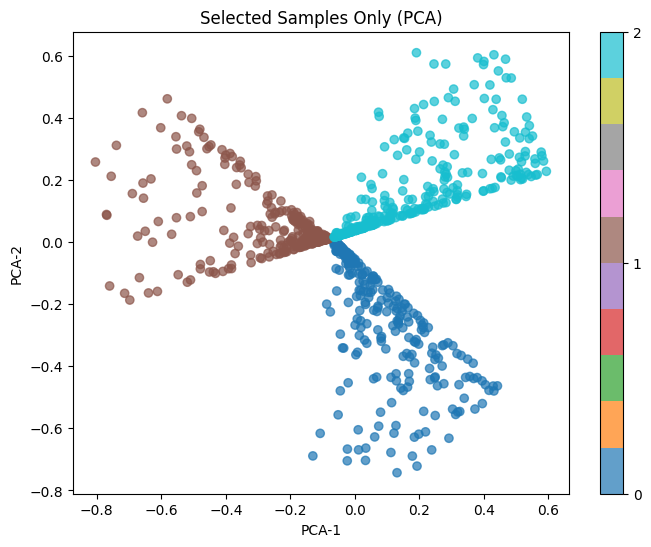

🔍 TSNE으로 임베딩 차원 축소 중...
✅ TSNE 차원 축소 완료!
✅ TSNE 시각화


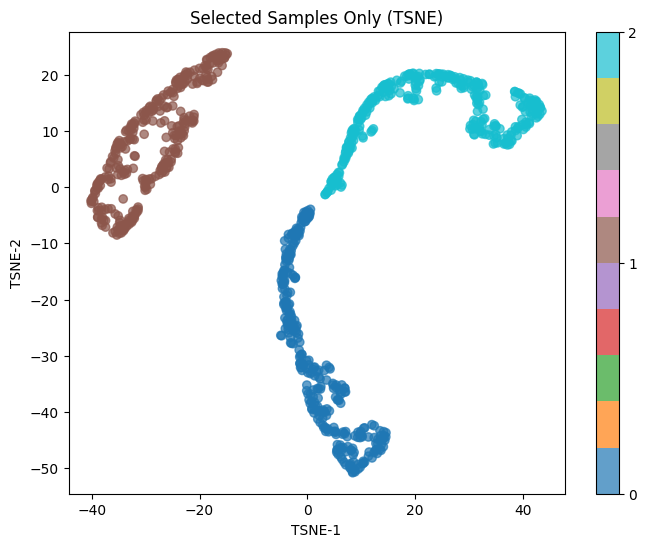

🔍 UMAP으로 임베딩 차원 축소 중...


/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP 차원 축소 완료!
✅ UMAP 시각화


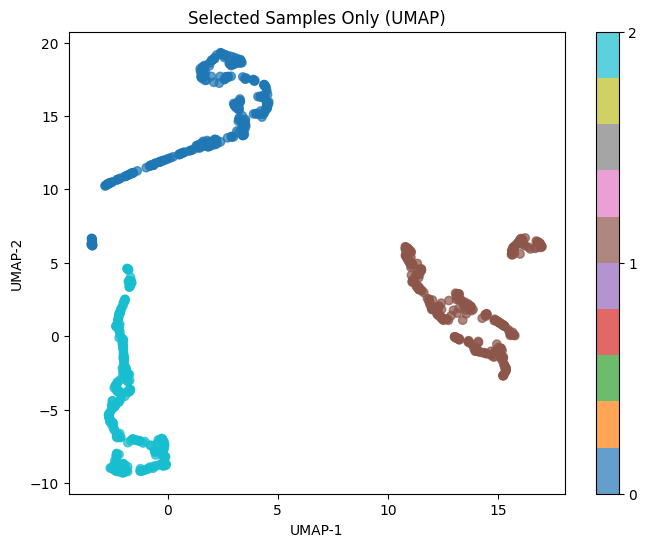

🔍 전체 vs 선택된 샘플 시각화 시작
🔍 PCA으로 임베딩 차원 축소 중...
✅ PCA 차원 축소 완료!
✅ PCA 시각화


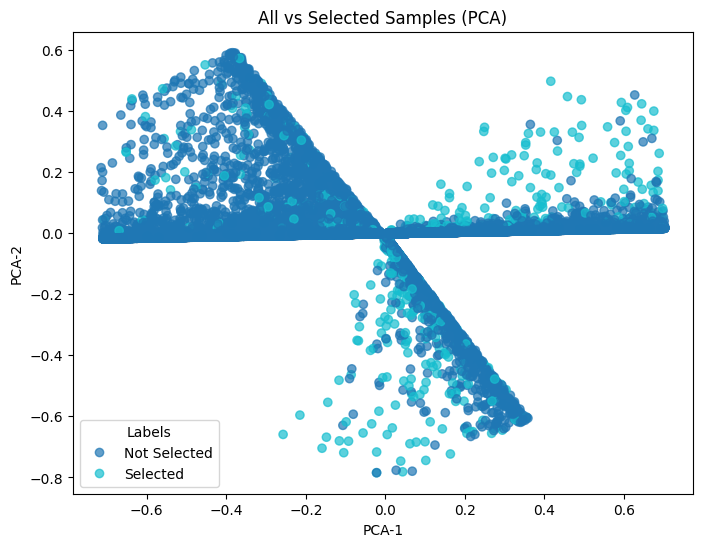

🔍 Margin vs Balanced-BADGE 시각화 시작
🔍 Margin vs Balanced-BADGE 비교 중...
🔍 UMAP으로 임베딩 차원 축소 중...


/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/elicer/FORIF_AI-study_team-ESG/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ UMAP 차원 축소 완료!
✅ UMAP 시각화


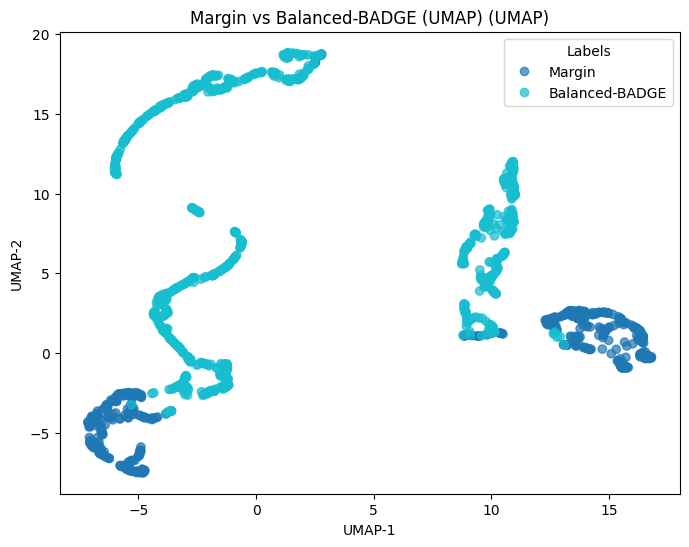

In [29]:
from collections import Counter

# 🔍 데이터 불러오기
unlabeled_df = pd.read_csv("unlabeled_esg_news.csv")
unlabeled_texts = unlabeled_df["text"].tolist()
print(f"🔍 전체 unlabeled 데이터 개수: {len(unlabeled_texts)}개")

# 🔍 모델 예측 확률
probs = get_predictions(model_path1, unlabeled_texts)
print(f"🔍 unlabeled 데이터 예측 확률 계산 완료: {probs.shape[0]}개")

# 🔍 BADGE 임베딩 생성
print("\n🔍 BADGE gradient embedding 생성 시작")
grad_embeds, pred_classes = simulate_badge_embeddings(probs)
# pred_classes = [int(c) for c in pred_classes]
grad_embeds = np.array(grad_embeds, dtype=np.float32)
print(f"🔍 BADGE gradient embedding 생성 완료: {grad_embeds.shape[0]}개")
print(f"📊 예측 클래스 개수: {len(np.unique(pred_classes))}개")
print(f"📊 예측 클래스 분포: {Counter(pred_classes)}")
class_counts = Counter(pred_classes)
class_ratio = {k: v / len(pred_classes) for k, v in class_counts.items()}
print(f"📊 예측 클래스 비율: {class_ratio}")

# 🔍 Balanced-BADGE 샘플링
print("\n🔍 Balanced-BADGE 샘플링 시작")
selected_idxs = balanced_badge_sampling(grad_embeds, pred_classes, num_per_class=300)
print(f"🔍 Balanced-BADGE 샘플링 완료: {len(selected_idxs)}개")
print(f"📊 Balanced-BADGE 샘플링 비율: {len(selected_idxs) / len(unlabeled_texts):.4f}")
print(f"📊 Balanced-BADGE 클래스 분포: {Counter(pred_classes[selected_idxs])}")
badge_counts = Counter(pred_classes[selected_idxs])
badge_ratio = {k: v / len(selected_idxs) for k, v in badge_counts.items()}
print(f"📊 Balanced-BADGE 클래스 비율: {badge_ratio}")

# 🔍 Margin Sampling
print("🔍 Margin Sampling 시작")
margin_selected_idxs = margin_sampling(probs, top_k=500)
print(f"🔍 Margin Sampling 샘플링 완료: {len(margin_selected_idxs)}개")
print(f"📊 Margin Sampling 샘플링 비율: {len(margin_selected_idxs) / len(unlabeled_texts):.4f}")
print(f"📊 Margin Sampling 클래스 분포: {Counter(pred_classes[margin_selected_idxs])}")
margin_counts = Counter(pred_classes[margin_selected_idxs])
margin_ratio = {k: v / len(margin_selected_idxs) for k, v in margin_counts.items()}
print(f"📊 Margin Sampling 클래스 비율: {margin_ratio}")

# ✅ 선택된 텍스트 저장
to_label_texts = [unlabeled_texts[i] for i in selected_idxs]
pd.DataFrame({"text": to_label_texts}).to_csv("to_label_round2.csv", index=False)
print("✅ Balanced-BADGE 기반 2차 라벨링 대상 저장 완료: to_label_round2.csv")

# 🔍 시각화: 선택된 샘플 분포
print("🔍 선택된 샘플 시각화 시작")
for method in ["pca", "tsne", "umap"]:
    plot_with_reduction(
        embeddings=grad_embeds[selected_idxs],
        labels=pred_classes[selected_idxs],
        method=method,
        title="Selected Samples Only"
    )

# 🔍 시각화: 전체 vs 선택
all_embeddings = grad_embeds
selection_mask = np.zeros(len(all_embeddings),dtype=int)
selection_mask[selected_idxs] = 1  # 1이면 선택됨

print("🔍 전체 vs 선택된 샘플 시각화 시작")
for method in ["pca"]:
    plot_with_reduction(
        embeddings=all_embeddings,
        labels=selection_mask,
        method=method,
        title="All vs Selected Samples",
        label_names=["Not Selected", "Selected"]
    )

# 🔍 Margin vs Balanced-BADGE 비교 시각화
print("🔍 Margin vs Balanced-BADGE 시각화 시작")
compare_margin_vs_badge(grad_embeds, margin_selected_idxs, selected_idxs)

# 👉👉👉👉 수작업 2차 레이블링 진행 👈👈👈👈

# 4. 데이터 통합

In [ ]:
print("\n[STEP 3] 2차 라벨링 데이터 로딩 및 통합 학습")
labeled2 = pd.read_csv("labeled_esg_news_round2.csv")
combined = pd.concat([labeled1, labeled2], ignore_index=True)
combined = combined.drop_duplicates(subset=["text"])
combined["label"] = combined["label"].astype(int)
dataset2 = Dataset.from_pandas(combined)
print(f"🔢 통합 라벨링 데이터 수: {len(combined)}")

In [ ]:
dataset2 = dataset2.rename_column("label", "labels")

In [ ]:
# ✅ Round2용 수정 사항 요약
# 1. 모델 로드시 AutoConfig 사용하여 구조 명시적으로 설정
# 2. trainer.train() 전에 classifier 구조 및 num_labels 출력
# 3. 'label' 컬럼을 'labels'로 rename 필요 (Trainer는 'labels'를 기본으로 사용함)
# 학습 함수
from transformers import AutoConfig, AutoModelForSequenceClassification
import os

def train_with_epochs(dataset, prefix, model_checkpoint):
    results = []

    # ✅ 1. 'label' → 'labels' 변경 (Trainer 기본 라벨 키)
    # if 'label' in dataset.column_names:
    #     dataset = dataset.rename_column("label", "labels")

    # ✅ 2. 데이터 분할
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    print(f"🔧 데이터 분할 완료: 학습 {len(dataset['train'])}개, 평가 {len(dataset['test'])}개")

    # os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# print("📦 classifier 확인:", model.classifier)
    for epoch in [7,8,9,10]:
        # ✅ 3. config 방식으로 모델 구조 명확히 설정
        config = AutoConfig.from_pretrained(model_checkpoint, num_labels=3)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_checkpoint,
            config=config
        ).to("cuda")

        # ✅ 4. 구조 디버깅 출력
        print("📦 분류기 구조:", model.classifier)
        print("🔧 num_labels 설정:", model.config.num_labels)
        
        print(f"[INFO] 🔁 Training {prefix} with epoch={epoch}")
        training_args = TrainingArguments(
            output_dir=f"./{prefix}-epoch-{epoch}",
            learning_rate=5e-5,
            per_device_train_batch_size=12,
            gradient_accumulation_steps=1,
            num_train_epochs=epoch,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=False,
            save_total_limit=None,
            logging_steps=50,
            report_to="none",
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["test"],
            tokenizer=tokenizer,
            data_collator=DataCollatorWithPadding(tokenizer),
            compute_metrics=compute_metrics
        )

        trainer.train()
        print(f"[INFO] ✅ Epoch {epoch} 학습 완료")
        metrics = trainer.evaluate()
        print("📊 평가 지표 반환 결과:", metrics) 
        print(f"[INFO] 📊 Epoch {epoch} 평가 결과: {metrics}")
        metrics["epoch"] = epoch

        checkpoint_dirs = sorted(glob.glob(os.path.join(training_args.output_dir, "checkpoint-*")))
        if checkpoint_dirs:
            metrics["model_save_path"] = checkpoint_dirs[-1]
        else:
            metrics["model_save_path"] = "Not found"
        results.append(metrics)

        print(f"[EPOCH {epoch}] Accuracy: {metrics['eval_accuracy']:.4f} | F1: {metrics['eval_f1']:.4f} | "
              f"Precision: {metrics['eval_precision']:.4f} | Recall: {metrics['eval_recall']:.4f}")
        print(f"[EPOCH {epoch}] 📁 Checkpoint 저장 경로: {metrics['model_save_path']}")
        print('------------------------------------------------------------------')

    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{prefix}_epoch_performance_report.csv", index=False)

    print("📊 전체 epoch 성능 요약:")
    summary_table = results_df[["epoch", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall", "model_save_path"]]
    print(tabulate(summary_table, headers="keys", tablefmt="github", showindex=False))

    print("📈 성능 그래프:")
    results_df.set_index("epoch")[["eval_accuracy", "eval_f1"]].plot(marker="o")
    plt.title(f"{prefix}: Epoch vs Accuracy/F1")
    plt.ylabel("Score")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.savefig(f"{prefix}_epoch_performance_plot.png")
    plt.show()

    print(f"✅ {prefix} 학습완료! 원하는 epoch의 모델을 선택하여 사용하세요.")
    print(f"🔎 결과 요약 파일: {prefix}_epoch_performance_report.csv")
    
    # (기존 epoch 루프 이후에 추가하세요)
    print("🔍 최종 모델로 과적합 점수 계산:")
    final_model = AutoModelForSequenceClassification.from_pretrained(results_df.iloc[-1]["model_save_path"]).to("cuda")
    trainer.model = final_model  # trainer에 새로 로드

    train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
    val_metrics = trainer.evaluate(eval_dataset=dataset["test"])

    overfit_score = train_metrics["eval_f1"] - val_metrics["eval_f1"]

    print(f"📊 Train F1: {train_metrics['eval_f1']:.4f}")
    print(f"📊 Val F1  : {val_metrics['eval_f1']:.4f}")
    print(f"📉 과적합 점수: {overfit_score:.4f}")

In [ ]:
dataset2 = dataset2.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True)
train_with_epochs(dataset2, "round2", "./round1-epoch-2/checkpoint-318")

print("📍 학습 완료! 'round2_epoch_performance_report.csv'를 확인 후 원하는 모델을 선택하세요.")

In [ ]:
# ✅ 로그 저장 실행 예시
save_epoch_performance_log(
    trainer_factory_fn=trainer_factory,
    dataset=dataset2,  # 또는 dataset1 등 라벨링된 데이터셋
    tokenizer=tokenizer,
    model_checkpoint="./round1-epoch-1/checkpoint-159",
    epochs=[7, 8, 9, 10],
    log_filename="performance_log_balanced_badge.csv"
)

In [ ]:
combined["label"].value_counts()

In [ ]:
# 사용자가 직접 선택한 epoch 값 입력
chosen_epoch = 10

# 모델 불러오기
model_path2 = load_model_from_epoch("round2_epoch_performance_report.csv", chosen_epoch)

In [ ]:
# 데이터 로드
print("[STEP 4] 최종 감성분석 실행")
samsung_df = pd.read('Samsung.csv')
hyundai_df = pd.read('Hyundai.csv')
kia_df = pd.read('Kia.csv')
lg_df = pd.read('LG.csv')
sk_df = pd.read('SK.csv')

In [ ]:
def get_sentiment_label(name, df):
    all_texts = df["text"].tolist()
    final_probs = get_predictions(model_path2, all_texts)
    final_preds = np.argmax(final_probs, axis=1)
    df["sentiment"] = final_preds
    df.to_csv(f"{name}_sentiment_result.csv", index=False)
    print(f"📁 {name} 감성분석 결과 저장 완료: {name}_sentiment_result.csv")
    return df

In [ ]:
samsung_result = get_sentiment_label("Samsung", samsung_df)
hyundai_result = get_sentiment_label("Hyundai", hyundai_df)
kia_result = get_sentiment_label("Kia", kia_df)
lg_result = get_sentiment_label("LG", lg_df)
sk_result = get_sentiment_label("SK", sk_df)